# Лабораторная работа №3. Логическая классификация
## Задание

1. выбрать датасет для классификации, например на [kaggle](https://www.kaggle.com/datasets?tags=13302-Classification);
   1. датасет должен содержать пропуски;
   2. датасет должен содержать категориальные и количественные признаки;
2. реализовать алгоритм построения дерева ID3 с разными критериями:
   1. критерий Донского;
   2. многоклассовый энтропийный критерий;
3. обучить дерево на выбранном датасете;
4. оценить качество классификации;
5. аналогично 1. - 4. решить задачу регрессии;
6. реализовать алгоритм редукции дерева;
7. сравнить качество классификации и регрессии до и после редукции дерева;
8. сравнить с [эталонной](https://scikit-learn.org/stable/) реализацией бинарного решающего дерева;
    1. сравнить качество работы;
    2. сравнить время работы;
9. подготовить небольшой отчет о проделанной работе.


## Примечание про задачу регрессии

В задаче регрессии в качестве меры неопределенности следует использовать среднеквадратичную ошибку. (см. Лекция 3, слайд 29).

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv('data/titanic.csv')


## Проверка датасета на условия лабораторной работы


In [3]:
# Проверка на наличие пропусков
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Датасет удовлетворяет условиям лабораторной работы. Пропуски присутствуют, есть как категориальные, так и количественные признаки.

### Подготовка датасета


In [5]:
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# Дропаем неинформативные признаки
df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)

In [7]:
# Преобразуем категориальные признаки в числовые
df['Sex'], sex_codes = pd.factorize(df['Sex'])
df['Embarked'], embarked_codes = pd.factorize(df['Embarked'])

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,0
1,1,1,1,38.0,1,0,71.2833,1
2,1,3,1,26.0,0,0,7.9250,0
3,1,1,1,35.0,1,0,53.1000,0
4,0,3,0,35.0,0,0,8.0500,0


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

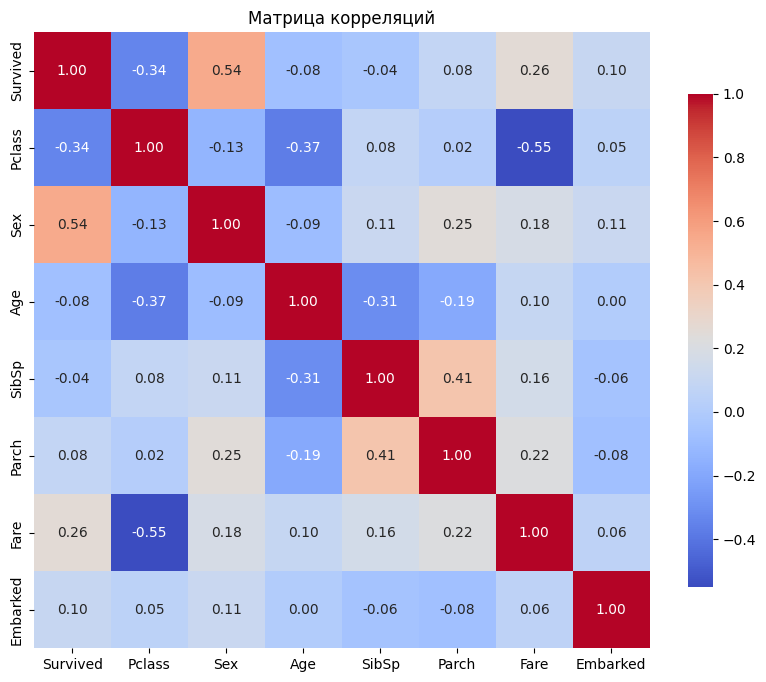

In [9]:
# Построение матрицы корреляций
correlation_matrix = df.corr()

# Визуализация матрицы корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Матрица корреляций')
plt.show()

У пола корреляция с таргетом 0.54, возможно, у женщин было больше шансов выжить, так как мужчины ринулись спасать. У платы за проед и класса билета 0.55, что звучит вполне логично, чем выше класс - тем дороже билет, но эти корреляции, на первый взгляд, не критичны, поэтому признаки оставляем.

In [10]:
y = df['Survived']
X = df.drop(['Survived'], axis=1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# Проверяем размеры выборок
print("Размер обучающей выборки:", X_train.shape[0])
print("Размер тестовой выборки:", X_test.shape[0])

Размер обучающей выборки: 623
Размер тестовой выборки: 268


Данные готовы, импортируем и тестируем модель.
Проверим глубину 5, 3 и 1 на моделях с разными критериями.

In [13]:
from id3_classifier import ID3Classifier
import time

In [14]:
# Данные готовы, импортируем и тестируем модель.
model_entropy_md_5 = ID3Classifier(criterion_type='entropy', max_depth=5)
start_time = time.time()
model_entropy_md_5.fit(X_train, y_train)
# Предсказание и оценка качества
predictions, accuracy = model_entropy_md_5.predict(X_test, y_test)
end_time = time.time()
res_time = end_time - start_time
# Визуализация структуры дерева
model_entropy_md_5.visualize_tree()

print(f"Точность на тестовой выборке: {accuracy:.4f}")
print(f"Время работы на тестовой выборке: {res_time:.4f} секунд")

Дерево решений для предсказания выживаемости на Титанике:
├── Женщина
├── Если Женщина:
    ├── Если Возраст <= 6.0 лет:
            ├── Выжил
        └── Если Количество членов семьи > 2:
                ├── Не выжил
            └── Если Возраст >= 2.0 лет:
                    ├── Выжил
                    └── Не выжил
    └── Если Возраст >= 6.0 лет:
        ├── Если Номер класса <= 1:
            ├── Если Стоимость билета <= 263.00$:
                    ├── Не выжил
                    └── Не выжил
                └── Выжил
        └── Если Номер класса > 1:
            ├── Если Возраст <= 32.0 лет:
                    ├── Не выжил
                    └── Не выжил
            └── Если Возраст >= 32.0 лет:
                    ├── Не выжил
                    └── Не выжил
└── Если Мужчина:
    ├── Если Номер класса <= 2:
        ├── Если Возраст <= 2.0 лет:
                ├── Не выжил
                └── Выжил
        └── Если Возраст >= 2.0 лет:
                ├── Выжил
           

In [15]:
# Данные готовы, импортируем и тестируем модель.
model_entropy_md_3 = ID3Classifier(criterion_type='entropy', max_depth=3)
start_time = time.time()
model_entropy_md_3.fit(X_train, y_train)
# Предсказание и оценка качества
predictions, accuracy = model_entropy_md_3.predict(X_test, y_test)
end_time = time.time()
res_time = end_time - start_time
# Визуализация структуры дерева
model_entropy_md_3.visualize_tree()

print(f"Точность на тестовой выборке: {accuracy:.4f}")
print(f"Время работы на тестовой выборке: {res_time:.4f} секунд")

Дерево решений для предсказания выживаемости на Титанике:
├── Женщина
├── Если Женщина:
    ├── Если Возраст <= 6.0 лет:
            ├── Выжил
            └── Не выжил
    └── Если Возраст >= 6.0 лет:
            ├── Не выжил
            └── Не выжил
└── Если Мужчина:
    ├── Если Номер класса <= 2:
            ├── Не выжил
            └── Выжил
    └── Если Номер класса > 2:
            ├── Не выжил
            └── Не выжил
Точность на тестовой выборке: 0.6493
Время работы на тестовой выборке: 0.2652 секунд


In [16]:
# Данные готовы, импортируем и тестируем модель.
model_entropy_md_1 = ID3Classifier(criterion_type='entropy', max_depth=1)
start_time = time.time()
model_entropy_md_1.fit(X_train, y_train)
# Предсказание и оценка качества
predictions, accuracy = model_entropy_md_1.predict(X_test, y_test)
end_time = time.time()
res_time = end_time - start_time
# Визуализация структуры дерева
model_entropy_md_1.visualize_tree()

print(f"Точность на тестовой выборке: {accuracy:.4f}")
print(f"Время работы на тестовой выборке: {res_time:.4f} секунд")

Дерево решений для предсказания выживаемости на Титанике:
├── Женщина
    ├── Не выжил
    └── Выжил
Точность на тестовой выборке: 0.7910
Время работы на тестовой выборке: 0.0978 секунд


In [17]:
# Данные готовы, импортируем и тестируем модель.
model_donsky_md_5 = ID3Classifier(criterion_type='donsky', max_depth=5)
start_time = time.time()
model_donsky_md_5.fit(X_train, y_train)
# Предсказание и оценка качества
predictions, accuracy = model_donsky_md_5.predict(X_test, y_test)
end_time = time.time()
res_time = end_time - start_time
# Визуализация структуры дерева
model_entropy_md_5.visualize_tree()

print(f"Точность на тестовой выборке: {accuracy:.4f}")
print(f"Время работы на тестовой выборке: {res_time:.4f} секунд")

Дерево решений для предсказания выживаемости на Титанике:
├── Женщина
├── Если Женщина:
    ├── Если Возраст <= 6.0 лет:
            ├── Выжил
        └── Если Количество членов семьи > 2:
                ├── Не выжил
            └── Если Возраст >= 2.0 лет:
                    ├── Выжил
                    └── Не выжил
    └── Если Возраст >= 6.0 лет:
        ├── Если Номер класса <= 1:
            ├── Если Стоимость билета <= 263.00$:
                    ├── Не выжил
                    └── Не выжил
                └── Выжил
        └── Если Номер класса > 1:
            ├── Если Возраст <= 32.0 лет:
                    ├── Не выжил
                    └── Не выжил
            └── Если Возраст >= 32.0 лет:
                    ├── Не выжил
                    └── Не выжил
└── Если Мужчина:
    ├── Если Номер класса <= 2:
        ├── Если Возраст <= 2.0 лет:
                ├── Не выжил
                └── Выжил
        └── Если Возраст >= 2.0 лет:
                ├── Выжил
           

In [18]:
# Данные готовы, импортируем и тестируем модель.
model_donsky_md_3 = ID3Classifier(criterion_type='donsky', max_depth=3)
# Предсказание и оценка качества
start_time = time.time()
model_donsky_md_3.fit(X_train, y_train)
predictions, accuracy = model_donsky_md_3.predict(X_test, y_test)
end_time = time.time()
res_time = end_time - start_time
# Визуализация структуры дерева
model_entropy_md_3.visualize_tree()

print(f"Точность на тестовой выборке: {accuracy:.4f}")
print(f"Время работы на тестовой выборке: {res_time:.4f} секунд")

Дерево решений для предсказания выживаемости на Титанике:
├── Женщина
├── Если Женщина:
    ├── Если Возраст <= 6.0 лет:
            ├── Выжил
            └── Не выжил
    └── Если Возраст >= 6.0 лет:
            ├── Не выжил
            └── Не выжил
└── Если Мужчина:
    ├── Если Номер класса <= 2:
            ├── Не выжил
            └── Выжил
    └── Если Номер класса > 2:
            ├── Не выжил
            └── Не выжил
Точность на тестовой выборке: 0.7985
Время работы на тестовой выборке: 14.7039 секунд


In [19]:
# Данные готовы, импортируем и тестируем модель.
model_donsky_md_1 = ID3Classifier(criterion_type='donsky', max_depth=1)
start_time = time.time()
model_donsky_md_1.fit(X_train, y_train)
# Предсказание и оценка качества
predictions, accuracy = model_donsky_md_1.predict(X_test, y_test)
end_time = time.time()
res_time = end_time - start_time
# Визуализация структуры дерева
model_entropy_md_3.visualize_tree()

print(f"Точность на тестовой выборке: {accuracy:.4f}")
print(f"Время работы на тестовой выборке: {res_time:.4f} секунд")

Дерево решений для предсказания выживаемости на Титанике:
├── Женщина
├── Если Женщина:
    ├── Если Возраст <= 6.0 лет:
            ├── Выжил
            └── Не выжил
    └── Если Возраст >= 6.0 лет:
            ├── Не выжил
            └── Не выжил
└── Если Мужчина:
    ├── Если Номер класса <= 2:
            ├── Не выжил
            └── Выжил
    └── Если Номер класса > 2:
            ├── Не выжил
            └── Не выжил
Точность на тестовой выборке: 0.7910
Время работы на тестовой выборке: 10.1043 секунд


In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [21]:
# Обучение модели scikit-learn
sklearn_entropy_md_5 = DecisionTreeClassifier(criterion='entropy', max_depth=5)
start_time = time.time()
sklearn_entropy_md_5.fit(X_train, y_train)
predictions2 = sklearn_entropy_md_5.predict(X_test)
end_time = time.time()
res_time = end_time - start_time
accuracy = accuracy_score(y_test, predictions2)

print(f"Точность модели scikit-learn: {accuracy:.4f}")
print(f"Время работы модели scikit-learn: {res_time:.4f} секунд")

Точность модели scikit-learn: 0.7948
Время работы модели scikit-learn: 0.0097 секунд


### Результаты тестов

1. model_entropy_md_5

- Точность: 0.6567
- Время: 0.5007 секунд

2. model_entropy_md_3

- Точность: 0.6493
- Время: 0.2652 секунд

3. model_entropy_md_1

- Точность: 0.7910
- Время: 0.0978 секунд

4. model_donsky_md_5

- Точность: 0.7425
- Время: 15.3828 секунд

5. model_donsky_md_3

- Точность: 0.7985
- Время: 14.7039 секунд

6. model_donsky_md_1

- Точность: 0.7910
- Время: 10.1043 секунд

7. sklearn_entropy_md_5

- Точность: 0.7948
- Время: 0.0097 секунд

### Выводы
С критерием донского алгоритм работает дольше.
По энтропии своя модель выдает лучшую точность с 1 узлом, критерий Донского - с 3.
Модель sklearn работает на порядок быстрее и выдает наибольшую точность среди моделей с max_depth = 5.

Применяем прунинг для модели с критерием Донского и глубиной 3.

In [22]:
# Выполняем прунинг
model_donsky_md_3.prune_tree(X_test, y_test)
model_donsky_md_3.visualize_tree()
# Оцениваем качество на тестовой выборке
predictions, accuracy = model_donsky_md_3.predict(X_test, y_test)
print(f"Точность на тестовой выборке после прунинга: {accuracy:.4f}")

Дерево решений для предсказания выживаемости на Титанике:
├── Женщина
├── Если Женщина:
    ├── Если Стоимость билета <= 15.50$:
            ├── Не выжил
            └── Не выжил
    └── Если Стоимость билета > 15.50$:
            ├── Не выжил
            └── Не выжил
└── Если Мужчина:
    ├── Если Номер класса <= 2:
            ├── Выжил
            └── Выжил
    └── Если Номер класса > 2:
            ├── Не выжил
            └── Выжил
Точность на тестовой выборке после прунинга: 0.7985


Глубина осталась 3.
Попробуем применить прунинг с изначальной глубиной 5.

In [23]:
# Применяем прунинг
model_donsky_md_5.prune_tree(X_test, y_test)
model_donsky_md_5.visualize_tree()
# Оцениваем качество на тестовой выборке
predictions, accuracy = model_donsky_md_5.predict(X_test, y_test)
print(f"Точность на тестовой выборке после прунинга: {accuracy:.4f}")

Дерево решений для предсказания выживаемости на Титанике:
├── Женщина
    ├── Не выжил
    └── Выжил
Точность на тестовой выборке после прунинга: 0.7910


### Сравнение
1. model_donsky_md_3
- После прунинга без изменений, точность: 0.7985

2. model_donsky_md_5
- После прунинга осталась только одна вершина.
- Точность до прунинга: 0.7425
- Точность после прунинга: 0.7910

Выводы: таргет сильно зависим от одного категориального признака.

### Регрессия
Возьмем другой признак (вещественный) за таргет - Fare (плату).

In [24]:
from id3_regressor import ID3Regressor, evaluate

In [25]:
y_reg = df['Fare']
X_reg = df.drop(['Fare'], axis=1)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

Глубина дерева: 5
Количество узлов: 45
MSE: 1659.5988
Время обучения: 0.1009 секунд


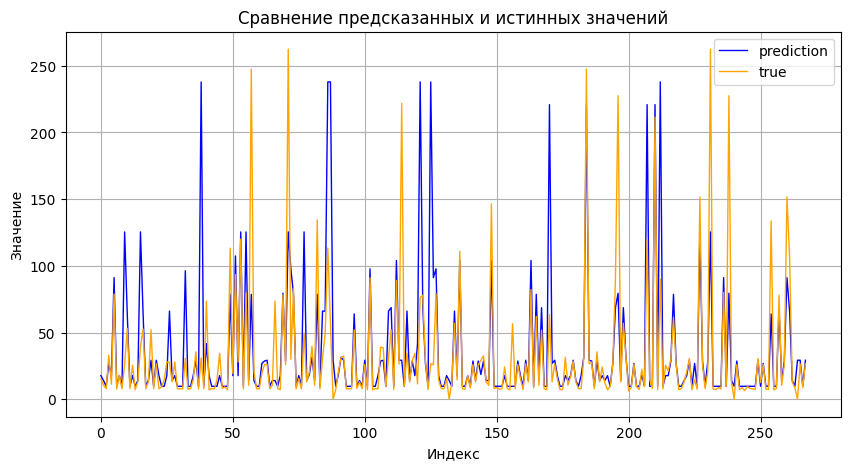

In [27]:
# Создаем модель и тестируем
depth = 5
model_reg = ID3Regressor(
    max_depth=depth,
    min_samples_split=10,
    min_samples_leaf=5
)

start_time = time.time()
model_reg.fit(X_train, y_train)

# Получаем предсказания
y_pred = model_reg.predict(X_test)

end_time = time.time()
train_time = end_time - start_time

# Вычисляем метрики
mse = evaluate(y_test, y_pred)

model_reg.print_tree_info(X_test, y_test)
print(f"Время обучения: {train_time:.4f} секунд")

# Создаем график
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_pred)), y_pred,
         label='prediction', color='blue', linewidth=1)
plt.plot(range(len(y_test)), y_test,
         label='true', color='orange', linewidth=1)
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.title('Сравнение предсказанных и истинных значений')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# Применяем прунинг
model_reg.prune_tree(X_test, y_test)

# Выводим информацию после прунинга
print("\nПосле прунинга:")
model_reg.print_tree_info(X_test, y_test)


После прунинга:
Глубина дерева: 5
Количество узлов: 19
MSE: 1245.0887


In [29]:
from sklearn.tree import DecisionTreeRegressor


Глубина дерева: 5
MSE: 1213.0605
Время обучения: 0.0000 секунд


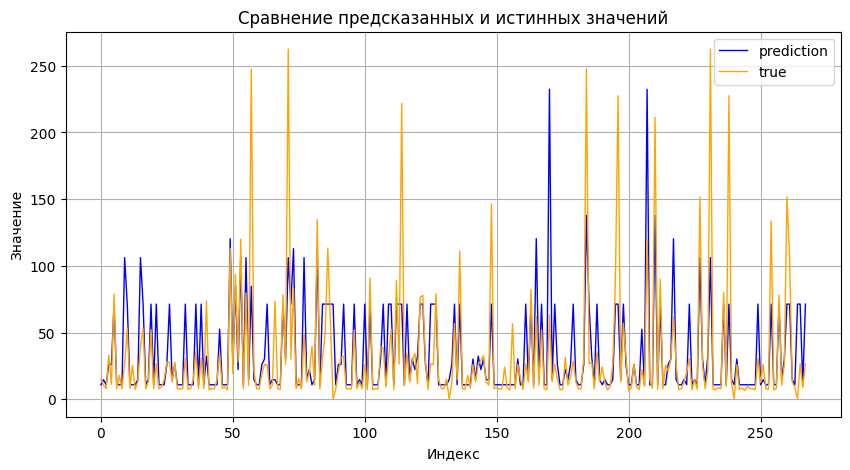

In [30]:
# Создаем модель и тестируем
depth = 5
sklearn_reg = DecisionTreeRegressor(
    max_depth=depth,
    min_samples_split=10,
    min_samples_leaf=5
)

start_time = time.time()
sklearn_reg.fit(X_train, y_train)

# Получаем предсказания
y_pred = sklearn_reg.predict(X_test)

end_time = time.time()
train_time = end_time - start_time

# Вычисляем метрики
mse = evaluate(y_test, y_pred)

print(f"\nГлубина дерева: {depth}")
print(f"MSE: {mse:.4f}")
print(f"Время обучения: {train_time:.4f} секунд")

# Создаем график
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_pred)), y_pred, 
         label='prediction', color='blue', linewidth=1)
plt.plot(range(len(y_test)), y_test, 
         label='true', color='orange', linewidth=1)
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.title('Сравнение предсказанных и истинных значений')
plt.legend()
plt.grid(True)
plt.show()

### Сравнение
1. model_reg до прунинга
Глубина дерева: 5
Количество узлов: 45
MSE: 1659.5988
Время обучения: 0.1009 секунд

2. model_reg после прунинга
Глубина дерева: 5
Количество узлов: 19
MSE: 1245.0887

3. sklearn_reg
Глубина дерева: 5
MSE: 1213.0605
Время обучения: 0.0000 секунд

### Выводы:
1. Модель от sklearn работает быстрее и метрика MSE немного точнее (это в том числе видно по графикам).
2. После прунинга, не смотря на такую же глубину, количество узлов значительно сократилось, а MSE получился лучше, чем с моделью skearn.